# LSTM Multivariate Model

In [1]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras. layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn import linear_model
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import math
import time
from math import sqrt
from sklearn.impute import KNNImputer

In [2]:
X_train = pd.read_csv('X_train_scaled.csv')
y_train = pd.read_csv('y_train_scaled.csv')
X_cv = pd.read_csv('X_val_scaled.csv')
y_cv = pd.read_csv('y_val_scaled.csv')
X_train_cv = pd.read_csv('X_train_val_scaled.csv')
y_train_cv = pd.read_csv('y_train_val_scaled.csv')
X_test = pd.read_csv('X_test_scaled.csv')
y_test = pd.read_csv('y_test_scaled.csv')

val =  pd.read_csv('val.csv')
y_val = pd.read_csv('y_val.csv')
test =  pd.read_csv('test.csv')
test_y = pd.read_csv('y_test.csv')

 ## Defining LSTM Model & MAPE Functions

In [3]:
def run(neurons, batchSize, numEpochs, X, Y, pred_set, orig, col_mean, col_std):
    #Reshaping
    trainX =np.array(X)
    X = trainX.reshape(X.shape[0], 1, X.shape[1])
    
    testX =np.array(pred_set)
    pred_set = testX.reshape(pred_set.shape[0], 1, pred_set.shape[1])
    
    #Building the LSTM Model
    lstm = Sequential()
    lstm.add(LSTM(neurons, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
    lstm.add(Dense(1))
    lstm.compile(loss="mean_squared_error", optimizer="adam")
    plot_model(lstm, show_shapes=True, show_layer_names=True)

    ##################################################
    
    # Fitting the RNN to the Training set
    history = lstm.fit(X, Y, epochs=numEpochs, batch_size=batchSize, verbose=1, shuffle=False)
    predicted_Price = lstm.predict(pred_set)
    
    predicted_price_df = pd.DataFrame(predicted_Price, columns=['Predicted Price'])
    
    # Scale Back Result
    est = predicted_price_df['Predicted Price'] * col_std + col_mean

    rmse = sqrt(mean_squared_error(orig, est))
    mape = get_mape(orig, est)
    
    # Calculate RMSE
    print("RMSE on train set = %0.3f" % rmse)
    # Calculate MAPE
    print("MAPE on train set = %0.3f%%" % mape)

    return rmse, mape

In [4]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Tuning Epochs Param

In [5]:
# vary training batches
param_label = 'epochs'
param_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
# param_list = [10]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32
default_neurons = 32

for param in param_list:
    rmse, mape = run(default_neurons, default_batch_size, param, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.7352
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.3235
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1348
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0940
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0750
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0663
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0566
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0493
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0436
Epoch 10/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0387
Epoch 11/50
14/14 [============================

14/14 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 49/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 50/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 51/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0181
Epoch 52/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0411
Epoch 53/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0358
Epoch 54/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0613
Epoch 55/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 56/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 57/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 58/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 59/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 60/100
14/14 [=====================

14/14 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 47/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 48/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 49/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 50/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 51/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0175
Epoch 52/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0275
Epoch 53/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0231
Epoch 54/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0328
Epoch 55/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0182
Epoch 56/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0191
Epoch 57/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 58/150
14/14 [=====================

14/14 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 147/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 148/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 149/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 150/150
14/14 [==============================] - 0s 2ms/step - loss: 0.0102
RMSE on train set = 3069.402
MAPE on train set = 18.817%
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/200
14/14 [==============================] - 1s 2ms/step - loss: 0.5882
Epoch 2/200
14/14 [==============================] - 0s 2ms/step - loss: 0.2993
Epoch 3/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1850
Epoch 4/200
14/14 [==============================] - 0s 2ms/step - loss: 0.1475
Epoch 5/200
14/14 [==============================] - 0s 2ms/step 

14/14 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 95/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 96/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 97/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 98/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 99/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0151
Epoch 100/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0113
Epoch 101/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 102/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 103/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0127
Epoch 104/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 105/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 106/200
14/14 [==============

14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 195/200
14/14 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 196/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 197/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 198/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 199/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 200/200
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
RMSE on train set = 3234.966
MAPE on train set = 19.132%
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/250
14/14 [==============================] - 1s 2ms/step - loss: 0.6395
Epoch 2/250
14/14 [==============================] - 0s 2ms/step - loss: 0.2532
Epoch 3/250
14/14 [==============================] - 0s 2ms/s

14/14 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 93/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0323
Epoch 94/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 95/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 96/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 97/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0137
Epoch 98/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 99/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 100/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 101/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 102/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 103/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 104/250
14/14 [================

14/14 [==============================] - 0s 3ms/step - loss: 0.0053
Epoch 193/250
14/14 [==============================] - 0s 3ms/step - loss: 0.0066
Epoch 194/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 195/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 196/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 197/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 198/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 199/250
14/14 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 200/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 201/250
14/14 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 202/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 203/250
14/14 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 204/250
14/14 [=========

Epoch 40/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0155
Epoch 41/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 42/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0119
Epoch 43/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 44/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 45/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 46/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 47/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 48/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 49/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 50/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 51/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 52/300
14/14 [========

14/14 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 141/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 142/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 143/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 144/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 145/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 146/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 147/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 148/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 149/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 150/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 151/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 152/300
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 241/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 242/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 243/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 244/300
14/14 [==============================] - 0s 3ms/step - loss: 0.0071
Epoch 245/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 246/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 247/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 248/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 249/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 250/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 251/300
14/14 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 252/300
14/14 [=========

Epoch 38/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 39/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 40/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 41/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 42/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 43/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 44/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 45/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0422
Epoch 46/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0381
Epoch 47/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0727
Epoch 48/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0206
Epoch 49/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0199
Epoch 50/350
14/14 [========

14/14 [==============================] - 0s 4ms/step - loss: 0.0083
Epoch 139/350
14/14 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 140/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 141/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 142/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 143/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0133
Epoch 144/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 145/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0138
Epoch 146/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0106
Epoch 147/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 148/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 149/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 150/350
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 239/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 240/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 241/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 242/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 243/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 244/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 245/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 246/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 247/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0085
Epoch 248/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0068
Epoch 249/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 250/350
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 339/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 340/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 341/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 342/350
14/14 [==============================] - 0s 1ms/step - loss: 0.0052
Epoch 343/350
14/14 [==============================] - 0s 1ms/step - loss: 0.0064
Epoch 344/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 345/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 346/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 347/350
14/14 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 348/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0054
Epoch 349/350
14/14 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 350/350
14/14 [=========

14/14 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 87/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 88/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 89/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 90/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 91/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 92/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 93/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 94/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 95/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 96/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 97/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 98/400
14/14 [=====================

14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 187/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 188/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 189/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 190/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 191/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 192/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 193/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 194/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 195/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 196/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 197/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 198/400
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0105
Epoch 287/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 288/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 289/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 290/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 291/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0056
Epoch 292/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0064
Epoch 293/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 294/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 295/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 296/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 297/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 298/400
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 387/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 388/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 389/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 390/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0059
Epoch 391/400
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 392/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 393/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 394/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 395/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 396/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 397/400
14/14 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 398/400
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 85/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 86/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0095
Epoch 87/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 88/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 89/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 90/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 91/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0128
Epoch 92/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0183
Epoch 93/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 94/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 95/450
14/14 [==============================] - 0s 5ms/step - loss: 0.0114
Epoch 96/450
14/14 [=====================

14/14 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 185/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 186/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0112
Epoch 187/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 188/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0100
Epoch 189/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 190/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 191/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0069
Epoch 192/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 193/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 194/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 195/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 196/450
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0066
Epoch 285/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 286/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 287/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0063
Epoch 288/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 289/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 290/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 291/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0074
Epoch 292/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 293/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 294/450
14/14 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 295/450
14/14 [==============================] - 0s 1ms/step - loss: 0.0069
Epoch 296/450
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 385/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 386/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 387/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 388/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 389/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 390/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 391/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0031
Epoch 392/450
14/14 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 393/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 394/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 395/450
14/14 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 396/450
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 32/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 33/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 34/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0117
Epoch 35/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 36/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 37/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 38/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 39/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 40/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 41/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 42/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0082
Epoch 43/500
14/14 [=====================

14/14 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 132/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 133/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0105
Epoch 134/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 135/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0094
Epoch 136/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 137/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 138/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 139/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 140/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0096
Epoch 141/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 142/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 143/500
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 232/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 233/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0083
Epoch 234/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0104
Epoch 235/500
14/14 [==============================] - 0s 4ms/step - loss: 0.0082
Epoch 236/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 237/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 238/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 239/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0073
Epoch 240/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 241/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 242/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 243/500
14/14 [=========

14/14 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 332/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 333/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 334/500
14/14 [==============================] - 0s 3ms/step - loss: 0.0065
Epoch 335/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 336/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 337/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 338/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 339/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0085
Epoch 340/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 341/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 342/500
14/14 [==============================] - 0s 2ms/step - loss: 0.0101
Epoch 343/500
14/14 [=========

14/14 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 432/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 433/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 434/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0016
Epoch 435/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 436/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0012
Epoch 437/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 438/500
14/14 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 439/500
14/14 [==============================] - 0s 1ms/step - loss: 8.9507e-04
Epoch 440/500
14/14 [==============================] - 0s 1ms/step - loss: 9.1343e-04
Epoch 441/500
14/14 [==============================] - 0s 1ms/step - loss: 8.2183e-04
Epoch 442/500
14/14 [==============================] - 0s 1ms/step - loss: 8.5345e-04
Epoch 443/500


,epochs,rmse,mape
0,50,2805.800177,18.589055
1,100,3231.740228,19.074873
2,150,3069.401895,18.817242
3,200,3234.965647,19.131704
4,250,2993.359679,18.923601
5,300,3304.581078,19.294989
6,350,3070.588164,19.034172
7,400,2960.241233,18.790857
8,450,2889.715798,18.837542
9,500,3082.487111,18.922223


In [6]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
epoch_opt = temp['epochs'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(epoch_opt))

min RMSE = 2805.800
optimum params = 50


In [7]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['epochs'].values[0]))

min MAPE = 18.589%
optimum params = 50


## Tuning Batch Size Parameter

In [8]:
# vary training batches
param_label = 'batch_size'
param_list = [32, 64, 128, 256]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_neurons = 32

for param in param_list:
    rmse, mape = run(default_neurons, param, epoch_opt, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
14/14 [==============================] - 2s 2ms/step - loss: 0.5426
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.2125
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1558
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1210
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0992
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0817
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 8/50
14/14 [==============================] - 0s 3ms/step - loss: 0.0563
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0468
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 11/50
14/14 [============================

7/7 [==============================] - 0s 3ms/step - loss: 0.0133
RMSE on train set = 2868.824
MAPE on train set = 18.606%
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
4/4 [==============================] - 1s 2ms/step - loss: 0.9951
Epoch 2/50
4/4 [==============================] - 0s 2ms/step - loss: 0.7942
Epoch 3/50
4/4 [==============================] - 0s 2ms/step - loss: 0.6235
Epoch 4/50
4/4 [==============================] - 0s 2ms/step - loss: 0.4705
Epoch 5/50
4/4 [==============================] - 0s 2ms/step - loss: 0.3399
Epoch 6/50
4/4 [==============================] - 0s 2ms/step - loss: 0.2392
Epoch 7/50
4/4 [==============================] - 0s 3ms/step - loss: 0.1770
Epoch 8/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1532
Epoch 9/50
4/4 [==============================] - 0s 2ms/step - loss: 0.1483
Epoch 10/50
4/4 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.0311
Epoch 50/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0299
RMSE on train set = 3214.738
MAPE on train set = 18.615%


,batch_size,rmse,mape
0,32,2979.925450,18.744441
1,64,2868.823559,18.606025
2,128,3021.515108,18.821502
3,256,3214.738383,18.614716


In [9]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
batch_size_opt = temp['batch_size'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(batch_size_opt))

min RMSE = 2868.824
optimum params = 64


In [10]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['batch_size'].values[0]))

min MAPE = 18.606%
optimum params = 64


In [11]:
# vary neurons
param_label = 'neurons'
param_list = [10, 20, 30, 40, 50]
error_rate = {param_label: [], 'rmse': [], 'mape': []}
default_batch_size = 32

for param in param_list:
    rmse, mape = run(param, default_batch_size, epoch_opt, X_train, y_train, X_cv, y_val, val['Close_mean'], val['Close_std'])
    
    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)

error_rate = pd.DataFrame(error_rate)
error_rate

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 1.2684
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.8824
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.6308
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.4372
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 0.3235
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 0.2732
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.2412
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 0.2161
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1934
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1735
Epoch 11/50
14/14 [============================

14/14 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 49/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0131
Epoch 50/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0108
RMSE on train set = 3148.553
MAPE on train set = 19.100%
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
14/14 [==============================] - 1s 2ms/step - loss: 0.9433
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 0.5748
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 0.3403
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 0.2413
Epoch 5/50
14/14 [==============================] - 0s 3ms/step - loss: 0.2035
Epoch 6/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1775
Epoch 7/50
14/14 [==============================] - 0s 2ms/step - loss: 0.1588


14/14 [==============================] - 0s 2ms/step - loss: 0.0225
Epoch 46/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 47/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0202
Epoch 48/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 49/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 50/50
14/14 [==============================] - 0s 2ms/step - loss: 0.0193
RMSE on train set = 2913.595
MAPE on train set = 18.752%
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
14/14 [==============================] - 1s 3ms/step - loss: 0.5538
Epoch 2/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1955
Epoch 3/50
14/14 [==============================] - 0s 3ms/step - loss: 0.1422
Epoch 4/50
14/14 [==============================] - 0s 2ms/step - loss: 0.11

,neurons,rmse,mape
0,10,2758.407038,18.323179
1,20,3148.552747,19.099504
2,30,2770.377266,18.604692
3,40,2913.595436,18.752438
4,50,2904.078144,18.701258


In [12]:
# Get optimum value for param 
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
neurons_opt = temp['neurons'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = " + str(neurons_opt))

min RMSE = 2758.407
optimum params = 10


In [13]:
# Get optimum value for param, using MAPE
temp = error_rate[error_rate['mape'] == error_rate['mape'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape'].min())
print("optimum params = " + str(temp['neurons'].values[0]))

min MAPE = 18.323%
optimum params = 10


## Model with Optimal Parameters

In [14]:
# Process the data for LSTM
testX =np.array(X_test)
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])
traincvX =np.array(X_train_cv)
X_train_cv = traincvX.reshape(X_train_cv.shape[0], 1, X_train_cv.shape[1])

In [15]:
# Building the LSTM Model

start = time.time()


lstm = Sequential()
lstm.add(LSTM(neurons_opt, input_shape=(1, traincvX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_squared_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

# Model Training
history = lstm.fit(X_train_cv, y_train_cv, epochs = epoch_opt, batch_size = batch_size_opt, verbose=1, shuffle=False)
# LSTM Prediction
y_pred = lstm.predict(X_test)

predicted_price_df = pd.DataFrame(y_pred, columns=['Predicted Price'])
    
# Scale Back Result
est = predicted_price_df['Predicted Price'] * test['Close_std'] + test['Close_mean']

end = time.time()
time_elapsed = end - start
print("Time Elapsed = ", time_elapsed)


rmse = sqrt(mean_squared_error(test_y, est))
mape = get_mape(test_y, est)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)
# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/50
10/10 [==============================] - 1s 2ms/step - loss: 0.8487
Epoch 2/50
10/10 [==============================] - 0s 3ms/step - loss: 0.6924
Epoch 3/50
10/10 [==============================] - 0s 2ms/step - loss: 0.5722
Epoch 4/50
10/10 [==============================] - 0s 2ms/step - loss: 0.4651
Epoch 5/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3748
Epoch 6/50
10/10 [==============================] - 0s 2ms/step - loss: 0.3063
Epoch 7/50
10/10 [==============================] - 0s 2ms/step - loss: 0.2555
Epoch 8/50
10/10 [==============================] - 0s 6ms/step - loss: 0.2155
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.1829
Epoch 10/50
10/10 [==============================] - 0s 2ms/step - loss: 0.1579
Epoch 11/50
10/10 [============================

In [16]:
est5 = est
est4 = est
est3 = est
est2 = est
est1 = est
est5

0      57275.086493
1      55417.161256
2      57233.968289
3      57738.824114
4      58686.376877
           ...     
140    39378.738953
141    39278.487164
142    41496.987230
143    43792.530579
144    46063.643525
Length: 145, dtype: float64

In [17]:
test5_y = test_y
test4_y = test_y
test3_y = test_y
test2_y = test_y
test1_y = test_y
test1_y

,Close
0,54663.6
1,57471.9
2,56004.5
3,57367.2
4,57344.9
...,...
140,37706.7
141,43179.8
142,44428.2
143,43896.9


In [18]:
delay_df_5 = test5_y.merge(est5.to_frame(), left_index=True, right_index=True)
delay_df_5 = delay_df_5.reset_index()
delay_df_5 = delay_df_5.drop(columns=['index'])
delay_df_5 = delay_df_5.to_numpy()
delay_df_5 = delay_df_5.flatten()
indexer_5 = np.arange(10)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_4 = test4_y.merge(est4.to_frame(), left_index=True, right_index=True)
delay_df_4 = delay_df_4.reset_index()
delay_df_4 = delay_df_4.drop(columns=['index'])
delay_df_4 = delay_df_4.to_numpy()
delay_df_4 = delay_df_4.flatten()
indexer_4 = np.arange(8)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_3 = test3_y.merge(est3.to_frame(), left_index=True, right_index=True)
delay_df_3 = delay_df_3.reset_index()
delay_df_3 = delay_df_3.drop(columns=['index'])
delay_df_3 = delay_df_3.to_numpy()
delay_df_3 = delay_df_3.flatten()
indexer_3 = np.arange(6)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_2 = test2_y.merge(est2.to_frame(), left_index=True, right_index=True)
delay_df_2 = delay_df_2.reset_index()
delay_df_2 = delay_df_2.drop(columns=['index'])
delay_df_2 = delay_df_2.to_numpy()
delay_df_2 = delay_df_2.flatten()
indexer_2 = np.arange(4)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

delay_df_1 = test1_y.merge(est1.to_frame(), left_index=True, right_index=True)
delay_df_1 = delay_df_1.reset_index()
delay_df_1 = delay_df_1.drop(columns=['index'])
delay_df_1 = delay_df_1.to_numpy()
delay_df_1 = delay_df_1.flatten()
indexer_1 = np.arange(2)[None, :] + 2*np.arange(140)[:, None] #sliding window indices

In [19]:
# window size 5
rmse_mean = 0
mape_mean = 0
for i in range(140-5+1):
    window = delay_df_5[indexer_5][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-5+1)  
mape_mean = mape_mean/(140-5+1) 

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 3386.432
MAPE on test set = 5.633%


In [20]:
# window size 4
rmse_mean = 0
mape_mean = 0
for i in range(140-4+1):
    window = delay_df_4[indexer_4][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-4+1)
mape_mean = mape_mean/(140-4+1) 

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 3318.806
MAPE on test set = 5.615%


In [21]:
# window size 3
rmse_mean = 0
mape_mean = 0
for i in range(140-3+1):
    window = delay_df_3[indexer_3][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-3+1)
mape_mean = mape_mean/(140-3+1)

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 3241.336
MAPE on test set = 5.595%


In [22]:
# window size 2
rmse_mean = 0
mape_mean = 0
for i in range(140-2+1):
    window = delay_df_2[indexer_2][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-2+1)
mape_mean = mape_mean/(140-2+1)

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 3146.669
MAPE on test set = 5.575%


In [23]:
# window size 1
rmse_mean = 0
mape_mean = 0
for i in range(140-1+1):
    window = delay_df_1[indexer_1][i]
    curr = 0
    est_list = []
    test_list = []
    for j in window:
        if curr%2==0:
            est_list.append(j)
        else:
            test_list.append(j)
        curr = curr + 1
    
    est_series = pd.Series(est_list, dtype='float64') 
    test_series = pd.Series(test_list, dtype='float64') 
    rmse_mean = rmse_mean + sqrt(mean_squared_error(test_series, est_series))
    mape_mean = mape_mean + get_mape(test_series, est_series)

rmse_mean = rmse_mean/(140-1+1)  
mape_mean = mape_mean/(140-1+1) 

print("RMSE on test set = %0.3f" % rmse_mean)
print("MAPE on test set = %0.3f%%" % mape_mean)

RMSE on test set = 3008.329
MAPE on test set = 5.557%


In [24]:
est = est[1:]
test_y = test_y[:-1]

est = est.reset_index(drop = True)
test_y = test_y.to_numpy()
test_y = test_y.flatten()
test_y = pd.Series(test_y) 

In [25]:
est

0      55417.161256
1      57233.968289
2      57738.824114
3      58686.376877
4      58853.440794
           ...     
139    39378.738953
140    39278.487164
141    41496.987230
142    43792.530579
143    46063.643525
Length: 144, dtype: float64

In [26]:
test_y

0      54663.6
1      57471.9
2      56004.5
3      57367.2
4      57344.9
        ...   
139    39119.1
140    37706.7
141    43179.8
142    44428.2
143    43896.9
Length: 144, dtype: float64

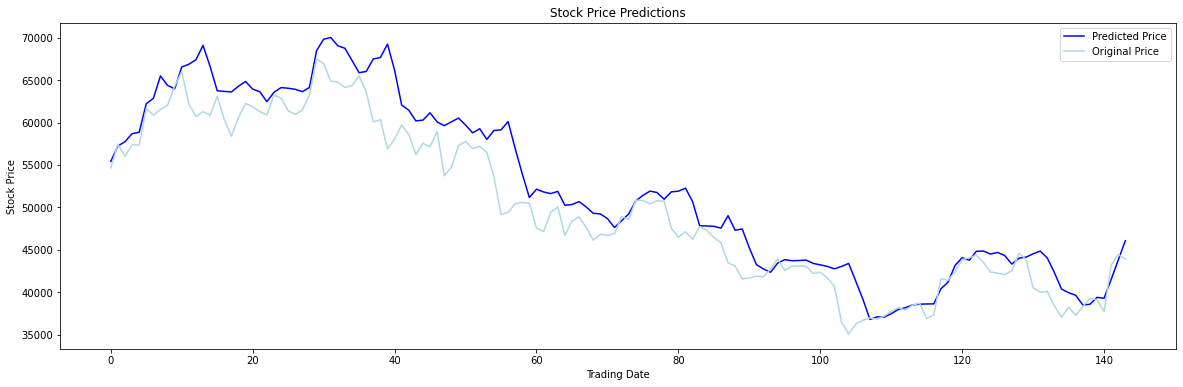

In [27]:
plt.plot(est, color = 'blue', label = 'Predicted Price')
plt.plot(test_y, color = 'lightblue', label = 'Original Price')
 
plt.title('Bitcoin Price Predictions')
plt.xlabel('Date')
plt.xticks(np.arange(0, 160, step=20))  
plt.ylabel('Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

## Prediction

In [28]:
predict_feature = pd.read_csv('predict_feature.csv')

In [29]:
# Process the data for LSTM
testX =np.array(predict_feature)
predict_feature = testX.reshape(predict_feature.shape[0], 1, predict_feature.shape[1])
predict_feature

array([[[-0.79500295,  0.99478636,  2.69379289, -0.91053679,
          0.30621419,  0.71920306, -0.32882933, -0.16651058,
         -1.43744719, -0.72267876,  0.94996311,  2.80817493,
         -0.91092801,  0.37921589,  0.64249732, -0.52598084,
         -0.24997117, -1.61802785, -0.75104984,  0.88965262,
          3.2483529 , -0.98726414,  0.59240154,  0.57416853,
         -0.66192609, -0.33907478, -1.78608512, -0.86170985,
          0.8319429 ,  2.8508659 , -0.91046227,  0.56229217,
          0.52108076, -0.81476911, -0.49192647, -1.90525532,
         -0.77804137,  0.84418974,  2.78690145, -1.02213244,
          0.67478063,  0.56252312, -0.65679442, -0.36023371,
         -1.62136398]]])

In [30]:
predicted_price = lstm.predict(predict_feature)

predicted_price_df = pd.DataFrame(predicted_price, columns=['Predicted Price'])
    
# Scale Back Result
close_mean = test['Close_mean'][-5:].mean()
close_std = test['Close_std'][-5:].mean()
est = predicted_price_df['Predicted Price'] * close_std + close_mean

In [31]:
est

0    42015.140625
Name: Predicted Price, dtype: float32

Reality: Bitcoin currency had a close price of USD 39,137.61 on 4 Mar 2022.

Prediced: Our model predicted the currency to have a close price of USD 40919.675781 on 4 Mar 2022.